# Batch Effect detection class

In [1]:
!pip -q install ./../../BatchDetect

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


## Reading metadata

In [57]:
import pandas as pd
from pathlib import Path
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
# create metadata dataframe from clini_table and folder structure
clini_table = pd.read_excel('/lustre/groups/peng/datasets/histology_data/clini_tables/TCGA-CRC-DX_CLINI.xlsx')

# metadata with columns: file, label (MSI-H), submission site
base_dir = Path('/home/haicu/sophia.wagner/datasets/BatchDetectTCGA/')
patch_list = list(base_dir.glob('*/*/*.jpeg'))
print(len(patch_list))

submission_site = [patch.parent.parent.name for patch in patch_list]
label = [clini_table.isMSIH[clini_table['PATIENT'] == patch.parent.name[:12]].item() for patch in patch_list]
metadata = pd.DataFrame(list(zip(patch_list, label, submission_site)), columns=['file', 'label', 'dataset'])

1420


In [50]:
metadata

,file,label,dataset
0,/home/haicu/sophia.wagner/datasets/BatchDetect...,nonMSIH,G4
1,/home/haicu/sophia.wagner/datasets/BatchDetect...,nonMSIH,G4
2,/home/haicu/sophia.wagner/datasets/BatchDetect...,nonMSIH,G4
3,/home/haicu/sophia.wagner/datasets/BatchDetect...,nonMSIH,G4
4,/home/haicu/sophia.wagner/datasets/BatchDetect...,nonMSIH,G4
...,...,...,...
1415,/home/haicu/sophia.wagner/datasets/BatchDetect...,nonMSIH,D5
1416,/home/haicu/sophia.wagner/datasets/BatchDetect...,nonMSIH,D5
1417,/home/haicu/sophia.wagner/datasets/BatchDetect...,nonMSIH,D5
1418,/home/haicu/sophia.wagner/datasets/BatchDetect...,nonMSIH,D5


## Features

In [47]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import copy
from skimage.transform import resize
from imageio import imread
import numpy as np

class DatasetGenerator(Dataset):

    def __init__(self, metadata, crop_size=64, transform=transforms.ToTensor()):
        self.metadata = metadata.copy().reset_index(drop = True)
        self.crop_size = crop_size
        self.transform = transform
        self.selected_channels = selected_channels

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        ## get image and label
        file_path = self.metadata.loc[idx,"file"]
        image= Image.open(file_path)

        label = self.metadata.loc[idx,"label"]
        
        if self.transform:
            image = self.transform(image) 
        return image.float(), label, idx

In [48]:
X_features = pd.DataFrame(index = metadata.index, columns = ["X" + str(i+1) for i in range(512) ])

In [5]:
from torchvision import transforms
import torch
import torch.nn as nn
import tqdm

from batch_detect.swin_transformer import swin_tiny_patch4_window7_224, ConvStem

feature_extractor = swin_tiny_patch4_window7_224(embed_layer=ConvStem, pretrained=False)
feature_extractor.head = nn.Identity()

ctranspath = torch.load('/home/haicu/sophia.wagner/models/ctranspath.pth')
feature_extractor.load_state_dict(ctranspath['model'], strict=True)
feature_extractor.eval()

for ds in  metadata["dataset"].unique():
    print(ds)
    dataset_index = metadata["dataset"] == ds
    dataset_index = dataset_index[dataset_index].index
    dataset = DatasetGenerator(metadata, 64, transforms.ToTensor())
    
    dataloader =  DataLoader(dataset, batch_size=64,shuffle=False, num_workers=4)
    
    with torch.no_grad():
        with torch.cuda.autocast()
        for data in dataloader: 
            idx = data[2].cpu().numpy()  
            inputs = data[0].cpu()
            inputs = inputs.float()
            features = feature_extractor(inputs).numpy().reshape((len(idx),512))
            X_features.loc[dataset_index[idx],:] = features
    dataset = None
    del dataset
    dataloader = None
    del dataloader

feature_extractor = None

Ace_20
Ace_20b
Mat_19
MLL_20


In [6]:
metadata.dataset.unique()

array(['Ace_20', 'Ace_20b', 'Mat_19', 'MLL_20'], dtype=object)

## Let's see if there is a batch effect in the data

In [7]:
from batchdetect import BatchDetect

bd = BatchDetect(metadata.loc[:,["label","dataset"]], X_features)

# visualizations

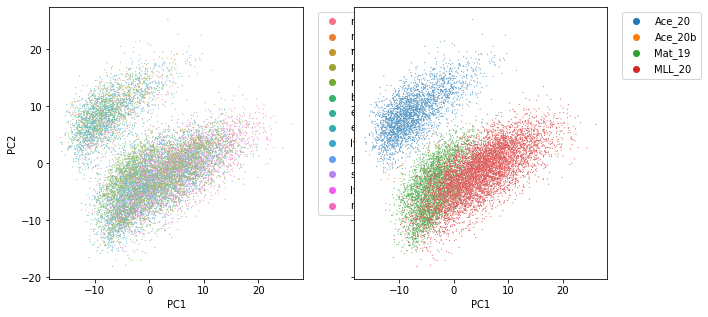

In [8]:
bd.low_dim_visualization("pca")

/home/icb/sayedali.boushehri/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/icb/sayedali.boushehri/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


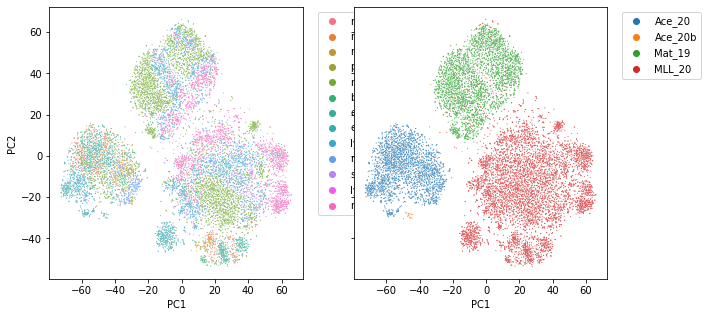

In [9]:
bd.low_dim_visualization("tsne")

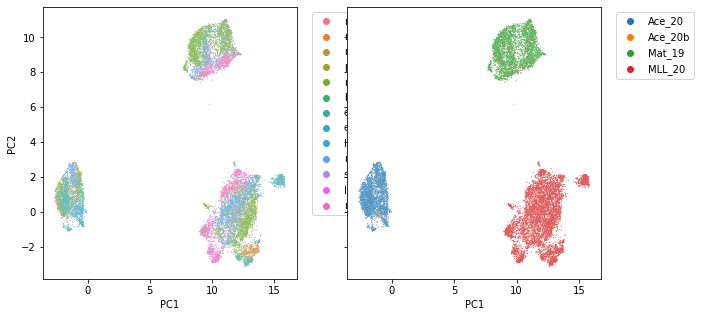

In [10]:
bd.low_dim_visualization("umap")

# Anova test of principal components vs. labels

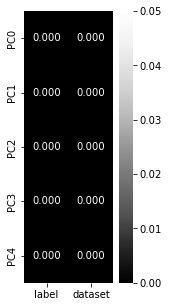

In [11]:
bd.prince_plot()

## classification test of  RF vs a random classifier

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   14.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.3min finished


comparing label : MannwhitneyuResult(statistic=0.0, pvalue=7.066071930388932e-18)
comparing dataset : MannwhitneyuResult(statistic=0.0, pvalue=7.051742525210717e-18)


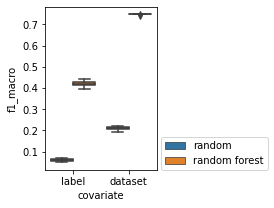

In [12]:
bd.classification_test(scorer="f1_macro")